# Linear Elasticity in 3D

## Introduction

This example provides a demonstration of using PyMKS to compute the linear strain field for a two-phase composite material in 3D, and presents a comparison of the computational efficiency of MKS, when compared with the finite element method. The example first provides information on the boundary conditions, used in MKS. Next, delta microstructures are used to calibrate the first-order influence coefficients. The influence coefficients are then used to compute the strain field for a random microstructure. Lastly, the calibrated influence coefficients are scaled up and are used to compute the strain field for a larger microstructure and compared with results computed using finite element analysis.

### Elastostatics Equations and Boundary Conditions

A review of the governing field equations for elastostatics can be found in the [Linear Elasticity in 2D](./elasticity.ipynb) example. The same equations are used in the example with the exception that the second lame parameter (shear modulus) $\mu$ is defined differently in 3D.

$$ \mu = \frac{E}{2(1+\nu)} $$


In general, generating the calibration data for the MKS requires boundary conditions that are both periodic and displaced, which are quite unusual boundary conditions. The ideal boundary conditions are given by:

$$ u(L, y, z) = u(0, y, z) + L\bar{\varepsilon}_{xx} $$
$$ u(0, L, L) = u(0, 0, L) = u(0, L, 0) = u(0, 0, 0) = 0  $$
$$ u(x, 0, z) = u(x, L, z) $$
$$ u(x, y, 0) = u(x, y, L) $$


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from numpy import random, array
import matplotlib.pyplot as plt
from pymks.fmks.data.delta import generate
from pymks.fmks.data.elastic_fe import solve
from pymks.fmks.plot import plot_microstructures
from sklearn.pipeline import Pipeline
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.localization import LocalizationRegressor, coeff_to_real

## Modeling with MKS

### Calibration Data and Delta Microstructures

The first-order MKS influence coefficients are all that is needed to compute a strain field of a random microstructure, as long as the ratio between the elastic moduli (also known as the contrast) is less than 1.5. If this condition is met, we can expect a mean absolute error of 2% or less, when comparing the MKS results with those computed using finite element methods [[1]](#ref1). 

Because we are using distinct phases and the contrast is low enough to only need the first order coefficients, delta microstructures and their strain fields are all that we need to calibrate the first-order influence coefficients [[2]](#ref2). 

The `generate` function from `pymks.fmks.data` can be used to create the two delta microstructures needed to calibrate the first-order influence coefficients for a two phase microstructure. This function uses the Python module [SfePy](http://sfepy.org/doc-devel/index.html) to compute the strain fields using finite element methods.

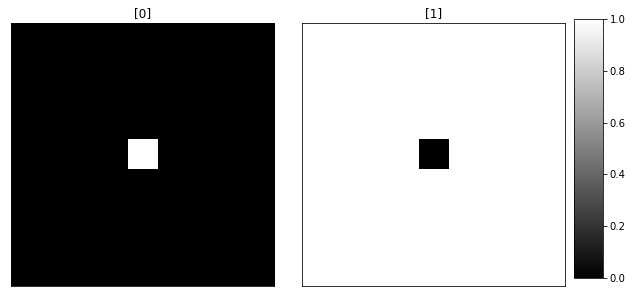

In [2]:
x_delta = generate(n_phases=2, shape=(9, 9, 9))

plot_microstructures(
    x_delta[0, x_delta.shape[1] // 2],
    x_delta[1, x_delta.shape[1] // 2],
    titles=['[0]', '[1]'],
    cmap='gray'
)

Using delta microstructures for the calibration of the first-order influence coefficients is essentially the same as using a unit [impulse response](http://en.wikipedia.org/wiki/Impulse_response) to find the kernel of a system in signal processing. Delta microstructures are composed of only two phases. One phase is located only at the center cell of the microstructure, and the rest made up of the other phase. 

### Generating Calibration Data

In this example, we look at a two-phase microstructure with elastic moduli values of 80 and 120 and Poisson's ratio values of 0.3 and 0.3, respectively. Let's also set the macroscopic imposed strain equal to 0.02. All of these parameters used in the simulation are used in the `solve` function from `pymks.fmks.data.elastic_fe` to calculate the elastic strain.  

In [3]:
strain_xx = lambda x: solve(
        x,
        elastic_modulus=(80, 120),
        poissons_ratio=(0.3, 0.3),
        macro_strain=0.02
    )['strain'][...,0]

y_delta = strain_xx(x_delta).compute()

Let's take a look at one of the delta microstructures and the $\varepsilon_{xx}$ strain field.

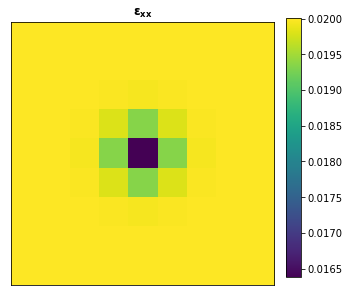

In [4]:
plot_microstructures(
    y_delta[0, x_delta.shape[1] // 2, :, :],
    titles=[r'$\mathbf{\varepsilon_{xx}}$']
)

### Calibrating First Order Influence Coefficients

Now that we have the delta microstructures and their strain fields, we can calibrate the influence coefficients by creating a model pipeline using the `PrimitiveTransformer` and the `LocalizationRegressor`.

In [5]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])

In [6]:
model.fit(x_delta, y_delta)

Pipeline(memory=None,
         steps=[('discretize',
                 PrimitiveTransformer(chunks=None, max_=1.0, min_=0.0,
                                      n_state=2)),
                ('regressor',
                 LocalizationRegressor(redundancy_func=<function LocalizationRegressor.<lambda> at 0x7fdc36f6a170>))],
         verbose=False)

That's it, the influence coefficient have been calibrated. Let's take a look at them.

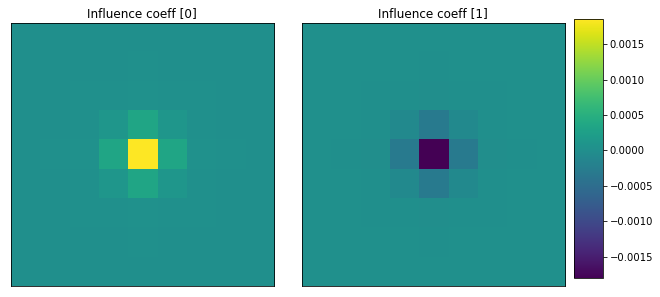

In [7]:
to_real = lambda x: coeff_to_real(x.steps[1][1].coeff).real

coeff = to_real(model)
plot_microstructures(
    coeff[x_delta.shape[1] // 2, :, :, 0],
    coeff[x_delta.shape[1] // 2, :, :, 1],
    titles=['Influence coeff [0]', 'Influence coeff [1]']
)

The influence coefficients have a Gaussian-like shape.

### Predict of the Strain Field for a Random Microstructure

Let's use the calibrated `model` to compute the strain field for a random two phase microstructure and compare it with the results from a finite element simulation. The `strain_xx` helper function is used to generate the strain field.

In [8]:
# NBVAL_IGNORE_OUTPUT

random.seed(99)
x_data = random.randint(2, size=(1,) + x_delta.shape[1:])
%time y_fe = strain_xx(x_data)

CPU times: user 1min 13s, sys: 21.3 s, total: 1min 34s
Wall time: 44.2 s


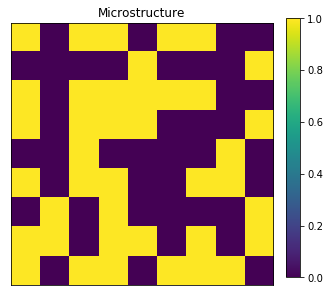

In [9]:
plot_microstructures(
    x_data[0, x_delta.shape[1] // 2, :, :],
    titles=['Microstructure']
)

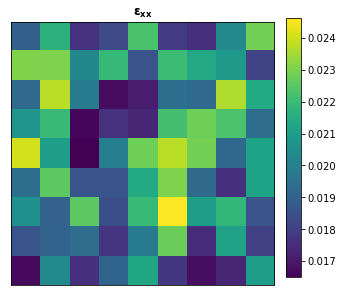

In [10]:
plot_microstructures(
    y_fe[0, x_delta.shape[1] // 2, :, :],
    titles=[r'$\mathbf{\varepsilon_{xx}}$']
)

**Note that the calibrated influence coefficients can only be used to reproduce the simulation with the same boundary conditions that they were calibrated with.**

Now to get the strain field from the model, pass the same microstructure to the `predict` method.

In [11]:
# NBVAL_IGNORE_OUTPUT

%time y_mks = model.predict(x_data).compute()

CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 21 ms


Finally let's compare the results from finite element simulation and the MKS model.

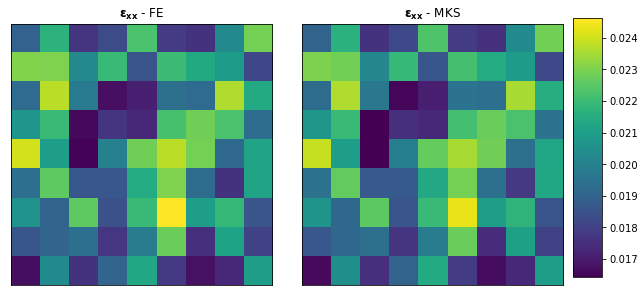

In [12]:
plot_microstructures(
    y_fe[0, x_delta.shape[1] // 2, :, :],
    y_mks[0, x_delta.shape[1] // 2, :, :],
    titles=[
        r'$\mathbf{\varepsilon_{xx}}$ - FE',
        r'$\mathbf{\varepsilon_{xx}}$ - MKS'
    ]
)

Let's look at the difference between the two plots.

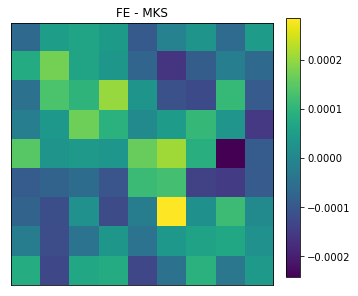

In [13]:
plot_microstructures(
    (y_fe - y_mks)[0, x_delta.shape[1] // 2, :, :],
    titles=['FE - MKS']
)

The MKS model is able to capture the strain field for the random microstructure after being calibrated with delta microstructures.

## Resizing the Coefficeints to use on Larger Microstructures 

The influence coefficients that were calibrated on a smaller microstructure can be used to predict the strain field on a larger microstructure though spectral interpolation [[3]](#ref3), but accuracy of the MKS model drops slightly. To demonstrate how this is done, let's generate a new larger $m$ by $m$ random microstructure and its strain field.

In [14]:
new_shape = tuple(array(x_delta.shape[1:]) * 3)
x_large = random.randint(2, size=(1,) + new_shape)

The influence coefficients that have already been calibrated need to be resized to match the shape of the new larger microstructure that we want to compute the strain field for. This can be done by passing the shape of the new larger microstructure into the `coeff_resize` method.

In [15]:
model.steps[1][1].coeff_resize(x_large[0].shape)

LocalizationRegressor(redundancy_func=<function LocalizationRegressor.<lambda> at 0x7fdc36f6a170>)

Use the resize coefficients to calculate large strain field. The coefficients can not now be used for the smaller microstructures.

In [16]:
# NBVAL_IGNORE_OUTPUT

%time y_large = model.predict(x_large).compute()

CPU times: user 41.3 ms, sys: 2.09 ms, total: 43.4 ms
Wall time: 38.2 ms


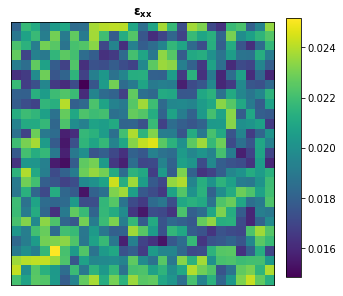

In [17]:
plot_microstructures(y_large[0, x_delta.shape[1] // 2], titles=[r'$\mathbf{\varepsilon_{xx}}$'])


## References

<a id="ref1"></a>
[1] Binci M., Fullwood D., Kalidindi S.R., *A new spectral framework for establishing localization relationships for elastic behav ior of composites and their calibration to finite-element models*. Acta Materialia, 2008. 56 (10): p. 2272-2282 [doi:10.1016/j.actamat.2008.01.017](http://dx.doi.org/10.1016/j.actamat.2008.01.017).

<a id="ref2"></a>
[2] Landi, G., S.R. Niezgoda, S.R. Kalidindi, *Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems*. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

<a id="ref3"></a>
[3] Marko, K., Kalidindi S.R., Fullwood D., *Computationally efficient database and spectral interpolation for fully plastic Taylor-type crystal plasticity calculations of face-centered cubic polycrystals*. International Journal of Plasticity 24 (2008) 1264–1276 [doi;10.1016/j.ijplas.2007.12.002](http://dx.doi.org/10.1016/j.ijplas.2007.12.002).